# Convolutional autoencoder for artifact removal

In [4]:
import torch, matplotlib.pyplot as plt, numpy as np, pickle
from torchvision import (datasets, transforms)
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
from torchinfo import summary
import torchvision.utils as vutils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import os
# set working dir to repo directory
head, tail = os.path.split(os.getcwd())
while tail != 'aj_python_tool_lib':
    head, tail = os.path.split(head)
os.chdir(os.path.join(head, tail))
#os.getcwd()
from neural_networks.nn_helper_functions import (conv2D_dims,conv2DT_dims);

In [6]:
data_path   = os.path.join('neural_networks', 'data')
mnist_data  = datasets.MNIST(root=data_path, train = False, transform = transforms.ToTensor())
batch_size = 32
data_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

img_shape = torch.tensor(mnist_data[0][0].shape)
img_n_pix = mnist_data[0][0].numel()
print(img_shape,img_n_pix)
#next(iter(data_loader))

tensor([ 1, 28, 28]) 784


__see file ./nn_helper_functions.ipynb__

In [11]:
conv_layer_params = torch.tensor([ #[ks , st, pd, pd_out,dil]
                                    [3  , 2 , 1 , -1    , -1],
                                    [3  , 2 , 1 , -1    , -1],
                                    [7  , 1 , 0 , -1    , -1]
])
param_names = ['kernel_size', 'stride', 'padding', 'output_padding', 'dilation']

conv_layer_params_d     = [{key:int(val) for key, val in zip(param_names, param_set) if val != -1} 
                            for param_set in conv_layer_params]

conv_T_layer_params = torch.tensor([   #[ks , st, pd    , pd_out, dil]
                                        [7  , 2 , -1    , -1    , -1 ],
                                        [3  , 2 , 1     ,  1    , -1 ],
                                        [3  , 2 , 1     ,  1    , -1 ]
                                    ])

param_names = ['kernel_size', 'stride', 'padding', 'output_padding', 'dilation']
conv_T_layer_params_d     = [{key:int(val) for key, val in zip(param_names, param_set) if val != -1} 
                            for param_set in conv_T_layer_params]

In [14]:
cc_in = 1
cc_l1 = 16
cc_l2 = 32
cc_l3 = 64

class Autoencoder_Conv(nn.Module):
    def __init__(self):

        super(Autoencoder_Conv, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(cc_in, cc_l1  , **conv_layer_params_d[0]),
            nn.ReLU(),
            nn.Conv2d(cc_l1, cc_l2  , **conv_layer_params_d[1]),
            nn.ReLU(),
            nn.Conv2d(cc_l2, cc_l3  , **conv_layer_params_d[2]),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(cc_l3, cc_l2 , **conv_T_layer_params_d[0]),
            nn.ReLU(),
            nn.ConvTranspose2d(cc_l2, cc_l1 , **conv_T_layer_params_d[1]),
            nn.ReLU(),
            nn.ConvTranspose2d(cc_l1, cc_in , **conv_T_layer_params_d[2]),
            nn.Sigmoid()
        )
        
    def forward(self,img):
        encoded = self.encoder(img)
        decoded = self.decoder(encoded)
        return decoded
    
model_conv = Autoencoder_Conv()
#summary(model_conv, input_size=tuple(img_shape))

[Salt and pepper noise by ANKUSH KUMAR (2023)](https://mackph.hashnode.dev/salt-and-pepper-in-python)

Modified for torch and batch

In [33]:
def add_s_p_noise(image_b, salt_ratio=0.05, pepper_ratio=0.05):

    batch_dims              = torch.tensor(image_b.shape)
    salt                    = torch.rand(*batch_dims, device=device) < salt_ratio
    pepper                  = torch.rand(*batch_dims, device=device) < pepper_ratio
    noisy_image_b           = image_b.clone()
    noisy_image_b[salt]     = 1
    noisy_image_b[pepper]   = 0

    return noisy_image_b

Add noise to a batch, but then compare reconstructed batch to uncorrupted images.

Network learns to denoise images

In [36]:
num_epochs = 10
output = []
OG = None
model_lin = model_conv.to(device)
criterion = nn.MSELoss()
optimizer = Adam(model_conv.parameters(), lr = 1e-3, weight_decay=1e-5)
for i in range(num_epochs):
    for img_b,_ in data_loader:
        img_b = img_b.to(device)

        img_b_noise = add_s_p_noise(img_b, salt_ratio=0.15, pepper_ratio=0.15)
        
        reconstruct = model_conv(img_b_noise)
        loss        = criterion(reconstruct, img_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        reconstruct_img_b = reconstruct.detach().to("cpu")
        grid = vutils.make_grid(reconstruct_img_b,nrow=4, normalize=True, pad_value=1)
    output.append(np.transpose(grid,(1,2,0)))
    OG = np.transpose(vutils.make_grid(img_b_noise,nrow=4, normalize=True, pad_value=1).detach().to("cpu"),(1,2,0))
    print('[%d\t/%d]Loss: %.4f'% (i, num_epochs, loss))#, end='\r')

[0	/10]Loss: 0.0086
[1	/10]Loss: 0.0088
[2	/10]Loss: 0.0081
[3	/10]Loss: 0.0084
[4	/10]Loss: 0.0094
[5	/10]Loss: 0.0084
[6	/10]Loss: 0.0080
[7	/10]Loss: 0.0073
[8	/10]Loss: 0.0091
[9	/10]Loss: 0.0079


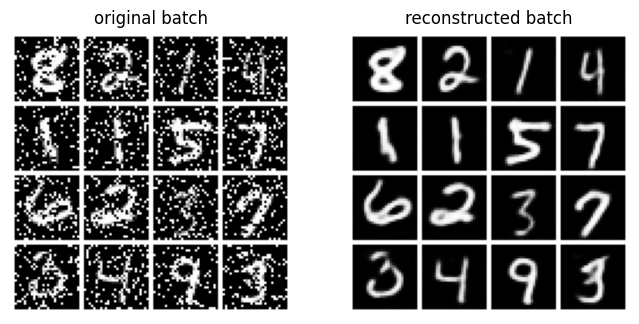

In [37]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8, 4))
ax[0].imshow(OG)
ax[0].set_title('original batch')
ax[1].imshow(output[-1])
ax[1].set_title('reconstructed batch')
ax[0].axis('off') 
ax[1].axis('off');